## Using pre-trained models for Texture Classification
In this lab, we will use pre-trained models for the same texture classification task. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

In [0]:
from __future__ import print_function
import os
import numpy as np
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import Model, Sequential
from tensorflow.python.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.applications import inception_v3
from matplotlib import pylab as plt



## Step 1: Load pre-trained InceptionV3 model
We will use the InceptionV3 model as the feature extractor for this classification task. First, we need to download the pre-trained weights. The model has been trained on the ImageNet image classification dataset. For more details on this dataset see http://www.image-net.org/. 

## InceptionV3 Model
Let's examine the InceptionV3 model. The model has the following specifications that are relevant for our task:
* Expected input size : 299x299 pixels
* Number of output classes : 1000

Our images are 150x150 pixels in size and come from only 10 categories. In order to use this model for our classification task, we need to do the following:
* Resize images : Our input images can be resized to the appropriate dimensions. Alternatively, we can pad our images to the expected dimensions. Padding leads to additional choices - Do we pad with zeros, duplicate edge pixels or mirror the image across edges ?
* Change the prediction layer : Remove the existing prediction layer and add a new layer that can predict 8 classes.
* Train : Finally, we need to train the network on our data

# Step 2
Load the data and resize images appropriately. Use the helper function in utils.py. The assumption is that you have already cloned the Week3 repo and know the path to the data folder.

In [0]:
def load_crc_data(data_dir):
    y = np.load(os.path.join(data_dir, 'rgb01.npz'))
    labels = y['labels']
    data = y['rgb_data']
    label_str = y['label_str']
    label_str = label_str.tolist() # this is to convert label_str back to a dictionary
    y = []

    for ii in range(2,6):
        filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
        print('loading ', filename)
        y = np.load(filename)
        labels = np.append(labels, y['labels'], axis=0)
        data = np.append(data, y['rgb_data'], axis=0)
        print(data.shape)

    return data, labels, label_str

In [3]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split
#! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git
os.chdir('..')
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')
data, labels, label_str = load_crc_data(data_dir)
num_images = data.shape[0]

loading  /Week3_public/data/crc/rgb02.npz
(2000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb03.npz
(3000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb04.npz
(4000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb05.npz
(5000, 150, 150, 3)


In [4]:
if 0 :
    # Resize data
    resized_data = np.zeros((num_images, 299, 299, 3))
    for ii in range(0, num_images):
        resized_data[ii,::] = resize(data[ii,::], (299, 299, 3), mode='symmetric')
    data = resized_data
    resized_data = []
    print(data.shape)
    with open('resized_299.npz', 'wb') as fp:
        np.savez(fp, data=data, labels=labels)
else:
    print('no image scaling')

no image scaling


In [0]:
# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(data.astype('float'), labels, test_size=.2)

In [0]:
if train_images[0,::].max() >200:
    train_images = train_images.astype('float')/255.
if test_images[0,::].max() >200:
    test_images = test_images.astype('float')/255.    

In [7]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(4000, 150, 150, 3)
(4000,)
(1000, 150, 150, 3)
(1000,)


In [7]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Step 3
We will now modify the pre-trained InceptionV3 network by adding a new classification layer.

In [8]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras import backend as K

# create the base pre-trained model
base_model = None
model = None
print('loading InceptionV3')
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
#base_model.summary()
print('done')

loading InceptionV3
done


In [7]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [9]:
# add a global spatial average pooling layer
x = None
model = None
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(64, activation='relu')(x)
# Add the final classification layer
predictions = Dense(8, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [10]:
# Freeze layers
#for layer in model.layers[:249]:
#    layer.trainable = False
#for layer in model.layers[249:]:
#    layer.trainable = False
model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

print('Trainable layers : ')
for l in model.layers:
    if l.trainable:
        print(l.name)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (


__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3, 3, 768)    0           activation_91[0][0]              
                                                                 activation_92[0][0]              
__________________________________________________________________________________________________
activation_93 (Activation)      (None, 3, 3, 192)    0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_85[0][0]              
                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
_________

In [11]:
# train the model on the new data for a few epochs
print('starting model training')
history = model.fit(train_images, train_labels, batch_size=64, epochs=15, verbose=1, validation_data=(test_images, test_labels))

starting model training
Train on 4000 samples, validate on 1000 samples
Epoch 1/15
4000/4000 [==============================] - 57s 14ms/step - loss: 0.8690 - acc: 0.7218 - val_loss: 10.5697 - val_acc: 0.3190
Epoch 2/15
4000/4000 [==============================] - 42s 11ms/step - loss: 0.5288 - acc: 0.8345 - val_loss: 13.8993 - val_acc: 0.1290
Epoch 3/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.3472 - acc: 0.8810 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 4/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.3013 - acc: 0.9050 - val_loss: 9.4825 - val_acc: 0.2730
Epoch 5/15
 384/4000 [=>............................] - ETA: 36s - loss: 0.3068 - acc: 0.8984

4000/4000 [==============================] - 43s 11ms/step - loss: 0.2462 - acc: 0.9160 - val_loss: 2.0142 - val_acc: 0.5930
Epoch 6/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.2043 - acc: 0.9347 - val_loss: 9.9051 - val_acc: 0.2680
Epoch 7/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.1585 - acc: 0.9540 - val_loss: 12.4892 - val_acc: 0.1490
Epoch 8/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.1461 - acc: 0.9553 - val_loss: 2.2113 - val_acc: 0.7540
Epoch 9/15
2688/4000 [===================>..........] - ETA: 13s - loss: 0.1330 - acc: 0.9587

4000/4000 [==============================] - 43s 11ms/step - loss: 0.1503 - acc: 0.9555 - val_loss: 3.0900 - val_acc: 0.6820
Epoch 10/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.1541 - acc: 0.9603 - val_loss: 5.9583 - val_acc: 0.4900
Epoch 11/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.1132 - acc: 0.9665 - val_loss: 1.3078 - val_acc: 0.8160
Epoch 12/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.1238 - acc: 0.9625 - val_loss: 4.5399 - val_acc: 0.5610
Epoch 13/15
2944/4000 [=====================>........] - ETA: 10s - loss: 0.0782 - acc: 0.9755

4000/4000 [==============================] - 43s 11ms/step - loss: 0.0846 - acc: 0.9742 - val_loss: 1.2183 - val_acc: 0.7900
Epoch 14/15
4000/4000 [==============================] - 42s 11ms/step - loss: 0.1029 - acc: 0.9695 - val_loss: 1.7288 - val_acc: 0.7530
Epoch 15/15
4000/4000 [==============================] - 43s 11ms/step - loss: 0.0809 - acc: 0.9785 - val_loss: 2.3042 - val_acc: 0.7470


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


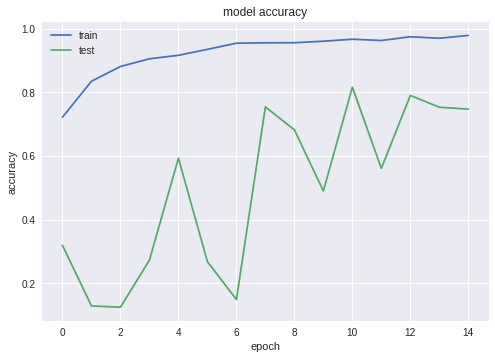

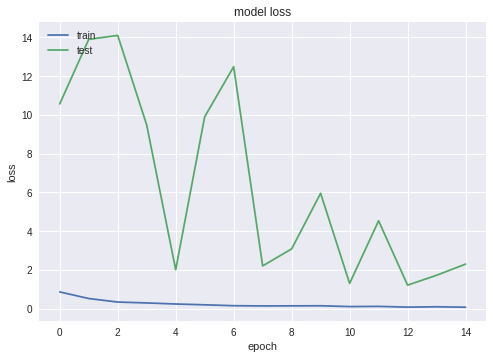

In [12]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Step 4
Freeze the layers that remain in our model.

In [0]:
predict = model.predict(test_images, verbose=1)

In [0]:
print(predict.shape)
id = np.argmax(predict, axis=1)
print(id.shape)
print(id[0])

plt.figure(figsize=(20,20))
for ii in range(0, 16):
    plt.subplot(4,4,ii+1)
    plt.imshow(test_images[ii+100])
    plt.axis('off')
    plt.title('expected : ' + label_str[np.argmax(test_labels[ii+100])]
              + '\npredicted : ' + label_str[id[ii+100]])
plt.show()